<a href="https://colab.research.google.com/github/umairaziz719/SoundSense-Sentiment-Analysis/blob/main/soundsense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tensorflow.keras import backend as K
from IPython.display import Audio
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,LSTM, Dense, Dropout, BatchNormalization,Dense, GRU, Dropout, Activation, GRU
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow.keras.layers as L
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install librosa==0.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.2.post1
    Uninstalling librosa-0.10.2.post1:
      Successfully uninstalled librosa-0.10.2.post1


##Loading Data

In [2]:
drive.mount('/content/drive')
!git clone https://github.com/umairaziz719/SoundSense-Sentiment-Analysis.git
paths = []
labels = []
dataset_path = '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data'
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Mounted at /content/drive
Cloning into 'SoundSense-Sentiment-Analysis'...
remote: Enumerating objects: 2862, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 2862 (delta 16), reused 9 (delta 1), pack-reused 2818
Receiving objects: 100% (2862/2862), 220.33 MiB | 43.12 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (2803/2803), done.
Dataset is Loaded


In [3]:
len(paths)

2800

In [4]:
paths[:5]

['/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_chain_ps.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_hall_ps.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_rat_ps.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_bath_ps.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_thought_ps.wav']

In [5]:
labels[:5]

['ps', 'ps', 'ps', 'ps', 'ps']

##Exploratory Analysis

In [6]:
data = {'speech': paths, 'label': labels}
df = pd.DataFrame(data)
df.head()

,speech,label
0,/content/SoundSense-Sentiment-Analysis/TESS To...,ps
1,/content/SoundSense-Sentiment-Analysis/TESS To...,ps
2,/content/SoundSense-Sentiment-Analysis/TESS To...,ps
3,/content/SoundSense-Sentiment-Analysis/TESS To...,ps
4,/content/SoundSense-Sentiment-Analysis/TESS To...,ps


In [7]:
print("Data Types of DataFrame Columns:")
print(df.dtypes)

Data Types of DataFrame Columns:
speech    object
label     object
dtype: object


In [8]:
df['label'].value_counts()

,count
label,
ps,400
disgust,400
angry,400
happy,400
sad,400
neutral,400
fear,400


<Axes: xlabel='label', ylabel='count'>

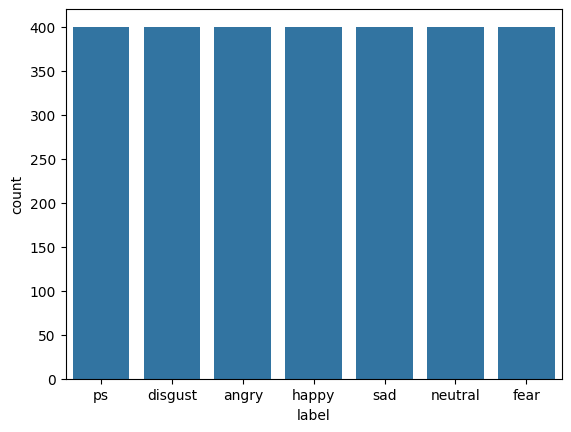

In [9]:
sns.countplot(data=df, x='label')

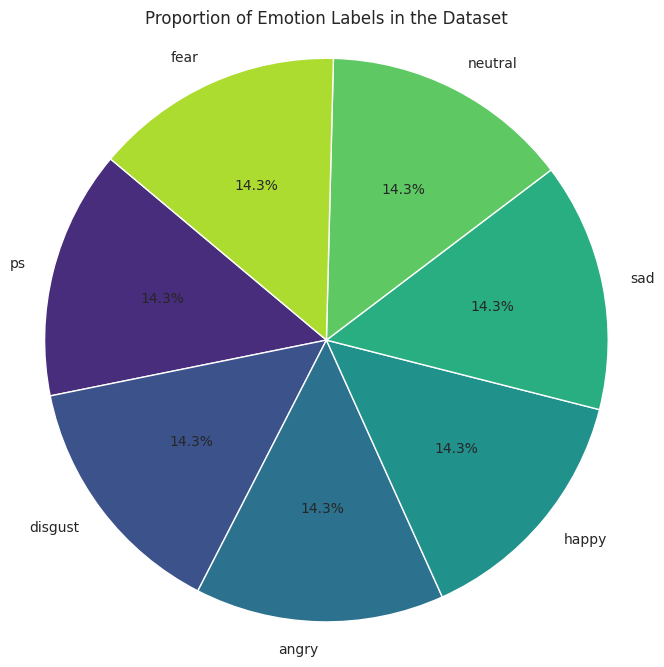

In [10]:
label_counts = df['label'].value_counts()
labels = label_counts.index
counts = label_counts.values
colors = sns.color_palette('viridis', len(labels))
sns.set_style("whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Emotion Labels in the Dataset')
plt.axis('equal')
plt.show()

In [11]:
def plot_wave(emotion):
    path = df.loc[df['label'] == emotion, 'speech'].values[0]
    data, sampling_rate = librosa.load(path)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].set_title(f'Waveform of {emotion}')
    axes[0].plot(data)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Amplitude')
    mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
    img = librosa.display.specshow(mfccs, x_axis='time', ax=axes[1])
    axes[1].set_title(f'MFCC of {emotion}')
    fig.colorbar(img, ax=axes[1])
    zero_crossings = librosa.feature.zero_crossing_rate(data)
    axes[2].set_title(f'Zero Crossing Rate of {emotion}')
    axes[2].plot(zero_crossings[0])
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Rate')
    plt.tight_layout()
    plt.show()
    return Audio(path)

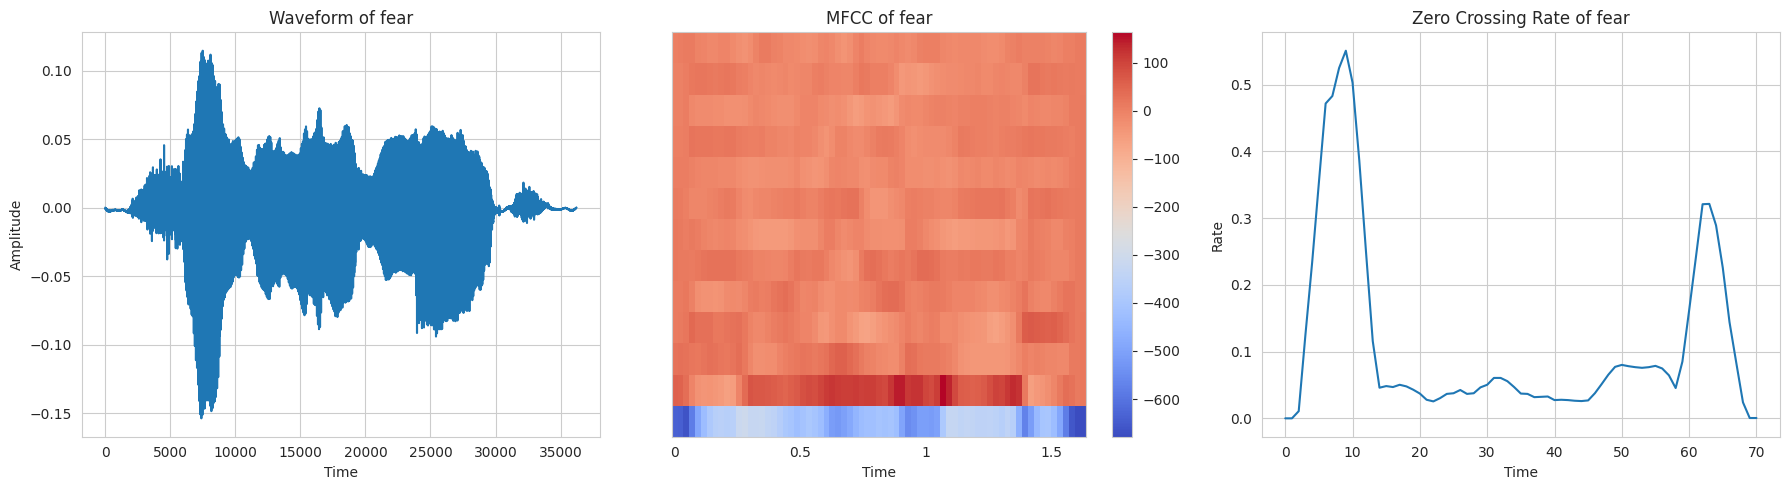

In [12]:
plot_wave('fear')

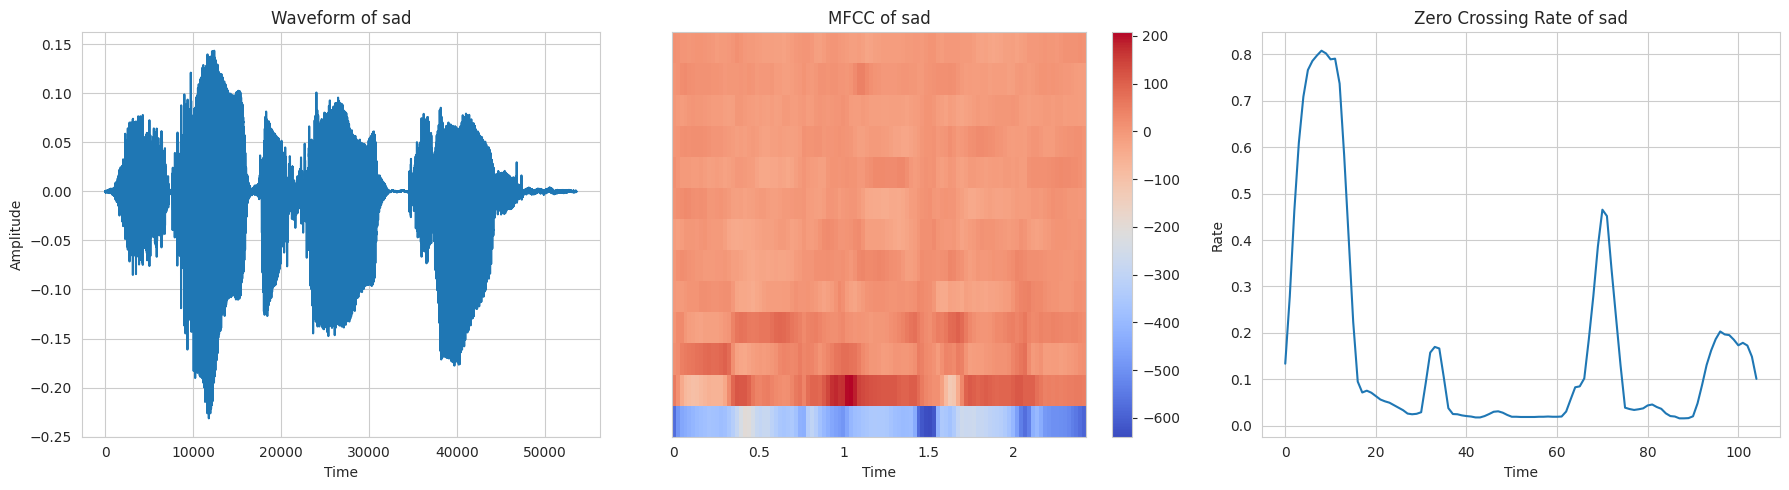

In [13]:
plot_wave('sad')

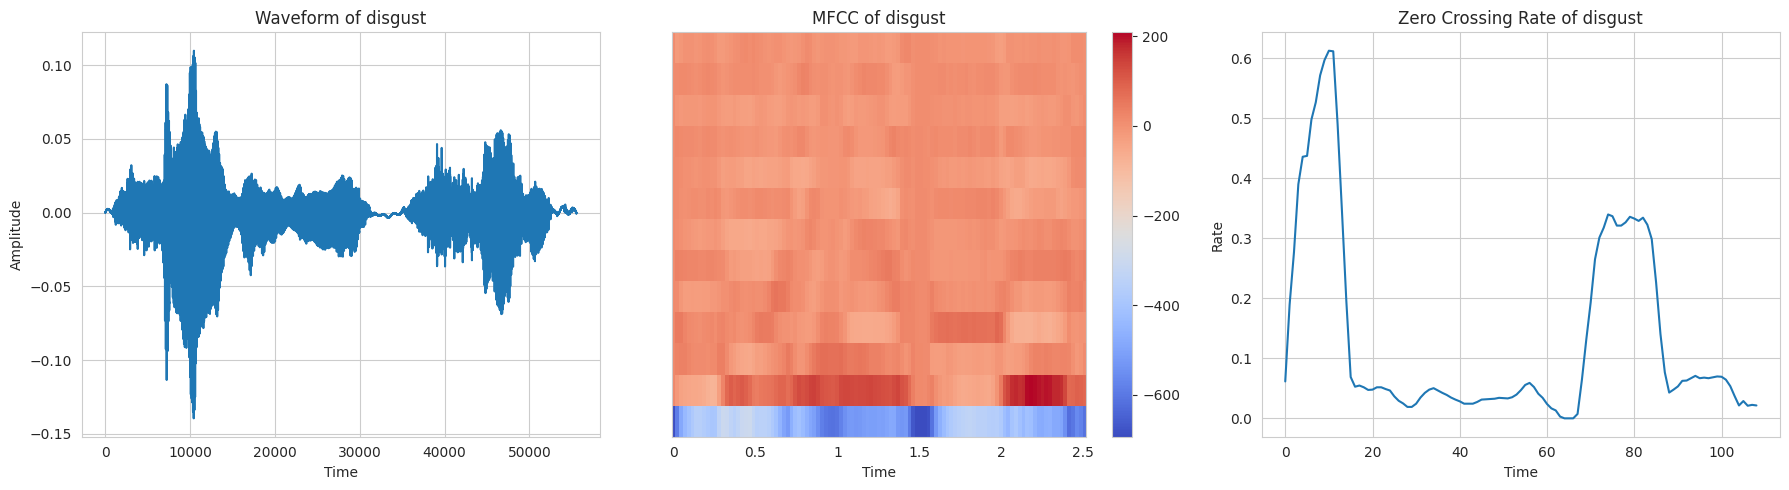

In [ ]:
plot_wave('disgust')

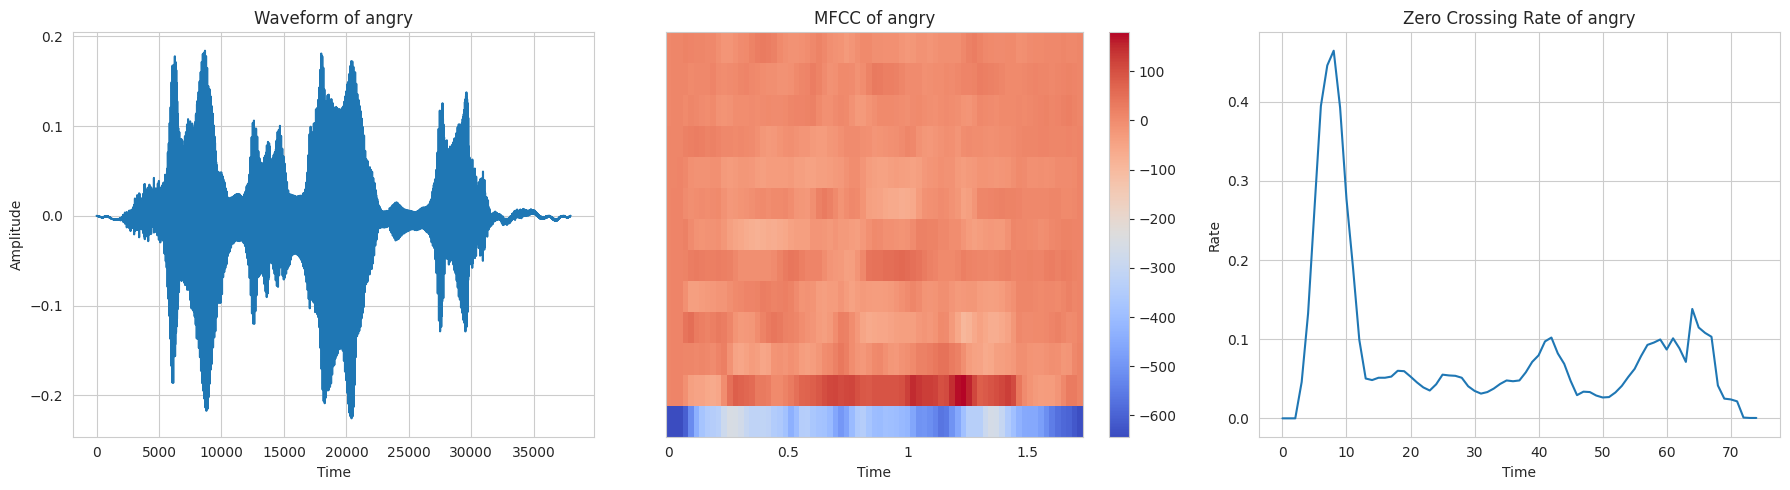

In [ ]:
plot_wave('angry')

##Data Agumentation Functions

In [13]:
class AudioProcessor:
    def __init__(self, file_path, duration=2.5, offset=0.6):
        self.file_path = file_path
        self.duration = duration
        self.offset = offset
        self.audio_data, self.sample_rate = self.load_audio()

    def load_audio(self):
        return librosa.load(self.file_path, duration=self.duration, offset=self.offset)

    def extract_audio_features(self, audio_data):
        output_result = np.array([])
        mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=self.audio_data).T,axis=0)
        output_result = np.hstack((output_result,mean_zero))
        stft_out = np.abs(librosa.stft(self.audio_data))
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out,sr=self.sample_rate).T,axis=0)
        output_result = np.hstack((output_result,chroma_stft))
        mfcc_out = np.mean(librosa.feature.mfcc(y=self.audio_data,sr=self.sample_rate).T,axis=0)
        output_result = np.hstack((output_result,mfcc_out))
        root_mean_out = np.mean(librosa.feature.rms(y=self.audio_data).T,axis=0)
        output_result = np.hstack((output_result,root_mean_out))
        mel_spectogram = np.mean(librosa.feature.melspectrogram(y=self.audio_data,sr=self.sample_rate).T,axis=0)
        output_result = np.hstack((output_result,mel_spectogram))

        return output_result

    def add_noise(self, audio_data):
        noise_value = 0.015 * np.random.uniform() * np.amax(audio_data)
        return audio_data + noise_value * np.random.normal(size=audio_data.shape[0])

    def stretch_process(self, audio_data, rate=0.8):
        return librosa.effects.time_stretch(audio_data, rate)

    def pitch_process(self, audio_data, pitch_factor=0.7):
        return librosa.effects.pitch_shift(audio_data, self.sample_rate, pitch_factor)

    def process_and_export_audio_features(self):

          output_1 = self.extract_audio_features(self.audio_data)
          result = np.array(output_1)

          noise_out = self.add_noise(self.audio_data)
          output_2 = self.extract_audio_features(noise_out)
          result = np.vstack((result,output_2))

          new_out = self.stretch_process(self.audio_data)
          strectch_pitch = self.pitch_process(new_out)
          output_3 = self.extract_audio_features(strectch_pitch)
          result = np.vstack((result,output_3))

          return result

In [14]:
class DataLoader:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.X_train = []
        self.y_train = []

    def load_data(self):
        for file_path, emotion_label in zip(self.dataframe['speech'], self.dataframe['label']):
            audio_processor = AudioProcessor(file_path)
            audio_features = audio_processor.process_and_export_audio_features()
            for feature_set in audio_features:
                self.X_train.append(feature_set)
                self.y_train.append(emotion_label)

        return np.array(self.X_train), np.array(self.y_train)


data_loader = DataLoader(df)
X_train, y_train = data_loader.load_data()


In [15]:
print(len(X_train))
print(len(y_train))
print(len(df['speech']))

8400
8400
2800


In [16]:
data = pd.DataFrame(X_train)
data["speech"] = y_train

In [17]:
data.head(-1)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,speech
0,0.135969,0.511700,0.495222,0.380886,0.413647,0.467791,0.483042,0.521995,0.555669,0.589553,...,0.001861,0.001301,0.000892,0.000600,0.000402,0.000139,0.000031,0.000005,1.347543e-07,ps
1,0.135969,0.511700,0.495222,0.380886,0.413647,0.467791,0.483042,0.521995,0.555669,0.589553,...,0.001861,0.001301,0.000892,0.000600,0.000402,0.000139,0.000031,0.000005,1.347543e-07,ps
2,0.135969,0.511700,0.495222,0.380886,0.413647,0.467791,0.483042,0.521995,0.555669,0.589553,...,0.001861,0.001301,0.000892,0.000600,0.000402,0.000139,0.000031,0.000005,1.347543e-07,ps
3,0.094512,0.657868,0.610691,0.442330,0.386212,0.497201,0.522937,0.442855,0.442440,0.427596,...,0.000158,0.000105,0.000174,0.000213,0.000183,0.000083,0.000020,0.000001,4.221275e-08,ps
4,0.094512,0.657868,0.610691,0.442330,0.386212,0.497201,0.522937,0.442855,0.442440,0.427596,...,0.000158,0.000105,0.000174,0.000213,0.000183,0.000083,0.000020,0.000001,4.221275e-08,ps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,0.098793,0.461140,0.317981,0.420183,0.537141,0.291748,0.394965,0.423610,0.686083,0.884620,...,0.000126,0.000247,0.000225,0.000187,0.000168,0.000048,0.000016,0.000002,2.485100e-07,neutral
8395,0.098793,0.461140,0.317981,0.420183,0.537141,0.291748,0.394965,0.423610,0.686083,0.884620,...,0.000126,0.000247,0.000225,0.000187,0.000168,0.000048,0.000016,0.000002,2.485100e-07,neutral
8396,0.098793,0.461140,0.317981,0.420183,0.537141,0.291748,0.394965,0.423610,0.686083,0.884620,...,0.000126,0.000247,0.000225,0.000187,0.000168,0.000048,0.000016,0.000002,2.485100e-07,neutral
8397,0.167604,0.388274,0.520203,0.597218,0.348523,0.261802,0.330286,0.627077,0.765294,0.479490,...,0.004983,0.005030,0.003166,0.001859,0.003267,0.001385,0.000245,0.000032,5.772225e-07,neutral


In [18]:
print(data["speech"].value_counts())

speech
ps         1200
disgust    1200
angry      1200
happy      1200
sad        1200
neutral    1200
fear       1200
Name: count, dtype: int64


##Preprocessing

In [19]:
class DataPreprocessor:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.encoder = OneHotEncoder(sparse=False)
        self.scaler = StandardScaler()

    def prepare_data(self):
        Y = self.encoder.fit_transform(self.y_train.reshape(-1, 1))
        X_train, X_val, y_train, y_val = train_test_split(self.X_train, Y, train_size=0.8, random_state=42, shuffle=True)
        n_features = X_train.shape[1]
        X_train = self.scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(X_train.shape)
        X_val = self.scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape)
        X_train = np.expand_dims(X_train, axis=2)
        X_val = np.expand_dims(X_val, axis=2)
        return X_train, X_val, y_train, y_val


In [20]:
preprocessor = DataPreprocessor(X_train, y_train)
X_train, X_val, y_train, y_val = preprocessor.prepare_data()
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(6720, 162, 1) (1680, 162, 1) (6720, 7) (1680, 7)


##CNN Model

In [ ]:
model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1),
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.25),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.25),

    L.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.25),

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.25),

    L.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.25),

    L.Flatten(),
    L.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    L.BatchNormalization(),
    L.Dropout(0.5),
    L.Dense(7, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00075, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 162, 512)            │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 162, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 81, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 81, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 81, 256)             │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 81, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 41, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 21, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 21, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 11, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 6, 64)               │              

 Total params: 1,002,311 (3.82 MB)

 Trainable params: 999,623 (3.81 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.4,min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/35
105/105 ━━━━━━━━━━━━━━━━━━━━ 108s 962ms/step - accuracy: 0.3076 - loss: 12.0633 - val_accuracy: 0.1685 - val_loss: 9.8108 - learning_rate: 7.5000e-04
Epoch 2/35
105/105 ━━━━━━━━━━━━━━━━━━━━ 142s 964ms/step - accuracy: 0.7310 - loss: 7.2902 - val_accuracy: 0.1399 - val_loss: 6.9743 - learning_rate: 7.5000e-04
Epoch 3/35
105/105 ━━━━━━━━━━━━━━━━━━━━ 96s 913ms/step - accuracy: 0.8570 - loss: 4.6211 - val_accuracy: 0.1696 - val_loss: 5.3646 - learning_rate: 7.5000e-04
Epoch 4/35
105/105 ━━━━━━━━━━━━━━━━━━━━ 142s 917ms/step - accuracy: 0.8974 - loss: 3.0530 - val_accuracy: 0.2435 - val_loss: 3.9719 - learning_rate: 7.5000e-04
Epoch 5/35
105/105 ━━━━━━━━━━━━━━━━━━━━ 144s 935ms/step - accuracy: 0.9128 - loss: 2.2080 - val_accuracy: 0.4137 - val_loss: 2.8132 - learning_rate: 7.5000e-04
Epoch 6/35
105/105 ━━━━━━━━━━━━━━━━━━━━ 142s 944ms/step - accuracy: 0.9165 - loss: 1.6458 - val_accuracy: 0.5917 - val_loss: 2.1386 - learning_rate: 7.5000e-04
Epoch 7/35
105/105 ━━━━━━━━━━━━━━━━━━━━ 

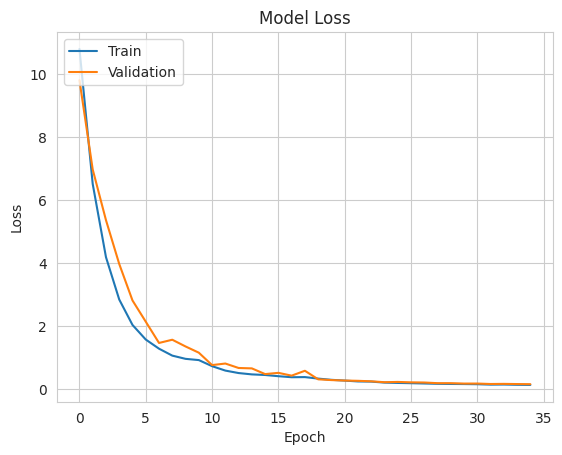

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

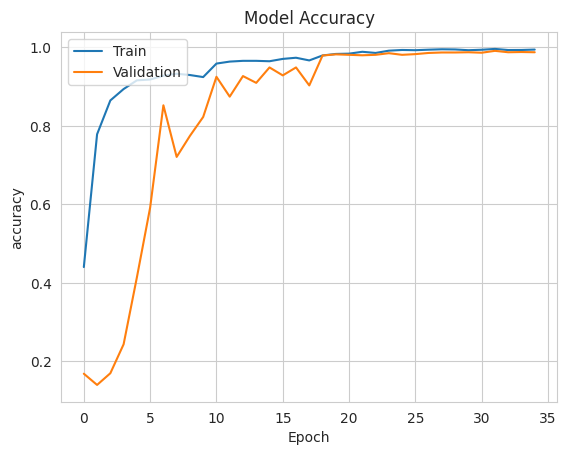

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
sample_size = 100
y_pred = model.predict(X_val[:sample_size])
y_pred_labels = preprocessor.encoder.inverse_transform(y_pred)
y_val_labels = preprocessor.encoder.inverse_transform(y_val[:sample_size])

df = pd.DataFrame({
    'Predicted Labels': y_pred_labels.flatten(),
    'Actual Labels': y_val_labels.flatten()
})

print(df)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step
   Predicted Labels Actual Labels
0                ps            ps
1             happy         happy
2             happy         happy
3           neutral       neutral
4           disgust       disgust
..              ...           ...
95             fear          fear
96             fear          fear
97          neutral       neutral
98            angry         angry
99            happy         happy

[100 rows x 2 columns]


In [ ]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

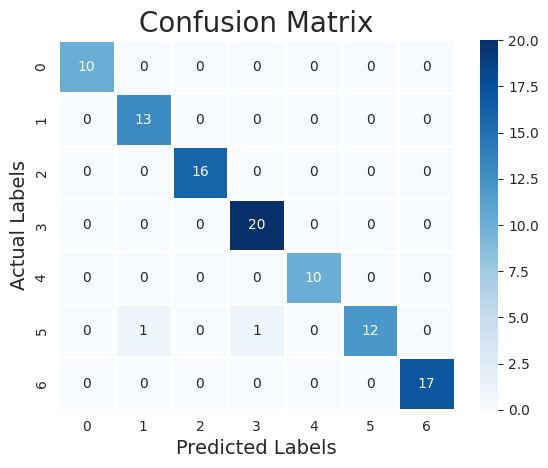

In [ ]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

##LSTM model

In [30]:
model1 = Sequential([
    LSTM(128, kernel_regularizer=l2(0.001), recurrent_dropout=0.2, return_sequences=True,
         kernel_constraint=MaxNorm(3), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(64, kernel_regularizer=l2(0.001), recurrent_dropout=0.2, return_sequences=True),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(32, kernel_regularizer=l2(0.001), return_sequences=True),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(7, activation='softmax')
])

optimizer = Adam(

    weight_decay=0.01,
    clipnorm=1
)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 162, 128)          66560     
                                                                 
 batch_normalization_15 (Ba  (None, 162, 128)          512       
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 162, 128)          0         
                                                                 
 lstm_13 (LSTM)              (None, 162, 64)           49408     
                                                                 
 batch_normalization_16 (Ba  (None, 162, 64)           256       
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 162, 64)          

In [31]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=4,
    verbose=1,
    mode='min',
    min_lr=1e-9
)

In [32]:
history1 = model1.fit(X_train, y_train,
                      epochs=35,
                      batch_size=128,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/35
53/53 [==============================] - ETA: 0s - loss: 2.2406 - accuracy: 0.2519
Epoch 1: val_loss improved from inf to 2.20521, saving model to best_model.keras
53/53 [==============================] - 40s 578ms/step - loss: 2.2406 - accuracy: 0.2519 - val_loss: 2.2052 - val_accuracy: 0.2060 - lr: 0.0010
Epoch 2/35
53/53 [==============================] - ETA: 0s - loss: 1.9944 - accuracy: 0.3009
Epoch 2: val_loss improved from 2.20521 to 2.14354, saving model to best_model.keras
53/53 [==============================] - 29s 551ms/step - loss: 1.9944 - accuracy: 0.3009 - val_loss: 2.1435 - val_accuracy: 0.2196 - lr: 0.0010
Epoch 3/35
53/53 [==============================] - ETA: 0s - loss: 1.8509 - accuracy: 0.3469
Epoch 3: val_loss improved from 2.14354 to 2.07555, saving model to best_model.keras
53/53 [==============================] - 29s 547ms/step - loss: 1.8509 - accuracy: 0.3469 - val_loss: 2.0755 - val_accuracy: 0.2387 - lr: 0.0010
Epoch 4/35
53/53 [==============

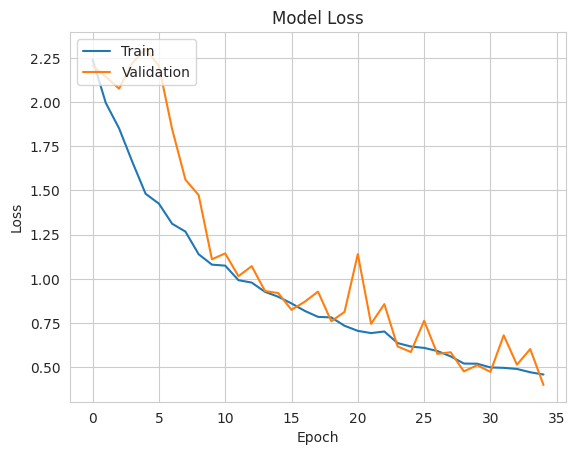

In [33]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

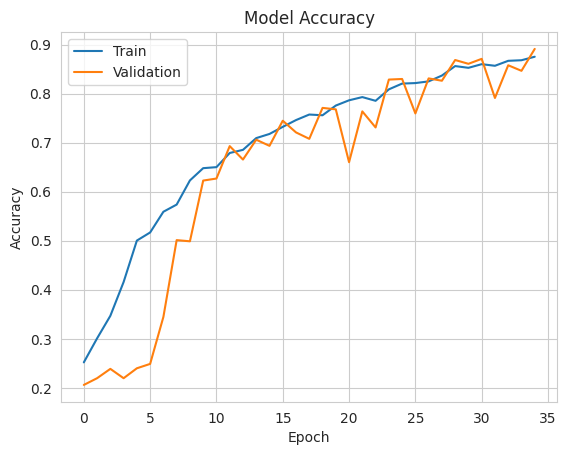

In [34]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
sample_size = 100
y_pred = model1.predict(X_val[:sample_size])
y_pred_labels = preprocessor.encoder.inverse_transform(y_pred)
y_val_labels = preprocessor.encoder.inverse_transform(y_val[:sample_size])

df = pd.DataFrame({
    'Predicted Labels': y_pred_labels.flatten(),
    'Actual Labels': y_val_labels.flatten()
})

print(df)

4/4 [==============================] - 1s 63ms/step
   Predicted Labels Actual Labels
0                ps            ps
1             happy         happy
2             happy         happy
3               sad           sad
4           neutral       neutral
..              ...           ...
95              sad           sad
96              sad           sad
97              sad           sad
98             fear          fear
99            happy         happy

[100 rows x 2 columns]


In [36]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

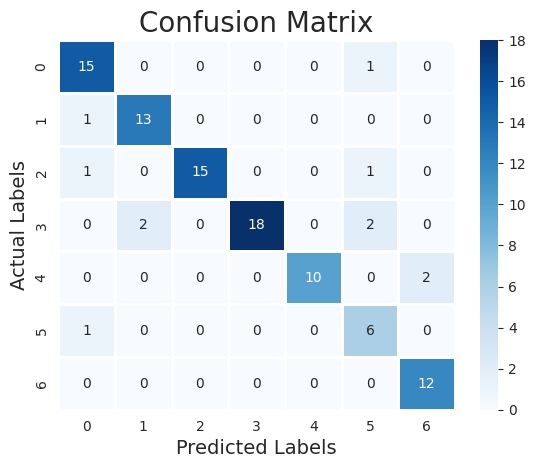

In [37]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

##GRU Model

In [ ]:
model2 = Sequential([
    GRU(256, input_shape=(X_train.shape[1], 1), return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    BatchNormalization(),
    Dropout(0.5),

    GRU(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    BatchNormalization(),
    Dropout(0.5),

    GRU(64, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    BatchNormalization(),
    Dropout(0.6),

    Dense(7, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam(weight_decay=1e-4, clipvalue=1.0)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 162, 256)          198912    
                                                                 
 batch_normalization_10 (Ba  (None, 162, 256)          1024      
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 162, 256)          0         
                                                                 
 gru_1 (GRU)                 (None, 162, 128)          148224    
                                                                 
 batch_normalization_11 (Ba  (None, 162, 128)          512       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 162, 128)         

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    verbose=1,
    patience=5,
    min_lr=0.00001
)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
history2 = model2.fit(X_train, y_train,epochs = 35,validation_data=(X_val, y_val), batch_size = 64, shuffle = True,callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/35
105/105 [==============================] - ETA: 0s - loss: 10.8220 - accuracy: 0.1750
Epoch 1: val_accuracy improved from -inf to 0.15179, saving model to best_model.keras
105/105 [==============================] - 60s 522ms/step - loss: 10.8220 - accuracy: 0.1750 - val_loss: 7.6847 - val_accuracy: 0.1518 - lr: 0.0010
Epoch 2/35
105/105 [==============================] - ETA: 0s - loss: 7.0266 - accuracy: 0.1949
Epoch 2: val_accuracy did not improve from 0.15179
105/105 [==============================] - 53s 507ms/step - loss: 7.0266 - accuracy: 0.1949 - val_loss: 5.7879 - val_accuracy: 0.1423 - lr: 0.0010
Epoch 3/35
105/105 [==============================] - ETA: 0s - loss: 5.2609 - accuracy: 0.2027
Epoch 3: val_accuracy improved from 0.15179 to 0.16905, saving model to best_model.keras
105/105 [==============================] - 54s 515ms/step - loss: 5.2609 - accuracy: 0.2027 - val_loss: 4.4984 - val_accuracy: 0.1690 - lr: 0.0010
Epoch 4/35
105/105 [=======================

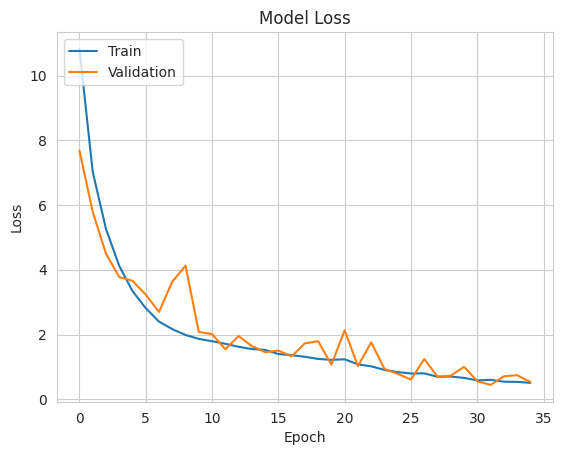

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

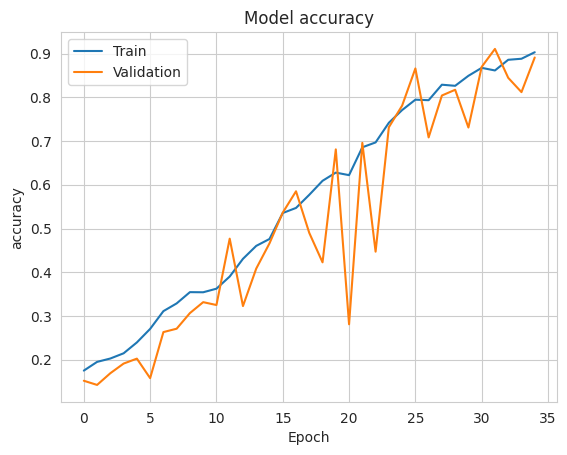

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
sample_size = 100
y_pred = model2.predict(X_val[:sample_size])
y_pred_labels = preprocessor.encoder.inverse_transform(y_pred)
y_val_labels = preprocessor.encoder.inverse_transform(y_val[:sample_size])


df = pd.DataFrame({
    'Predicted Labels': y_pred_labels.flatten(),
    'Actual Labels': y_val_labels.flatten()
})

print(df)

4/4 [==============================] - 1s 91ms/step
   Predicted Labels Actual Labels
0           disgust            ps
1           neutral          fear
2              fear          fear
3           disgust       disgust
4           disgust       disgust
..              ...           ...
95              sad           sad
96              sad           sad
97          disgust       disgust
98            happy         happy
99             fear          fear

[100 rows x 2 columns]


In [ ]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

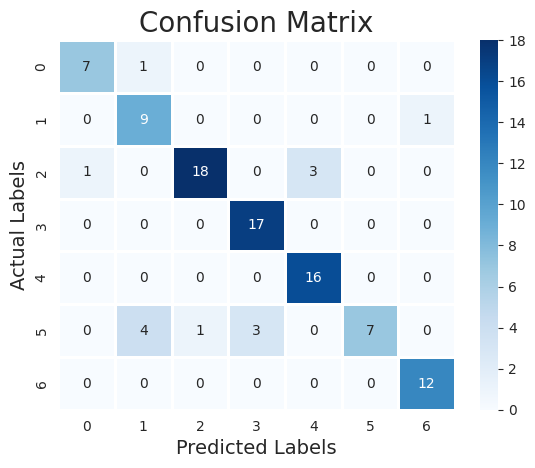

In [ ]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
X = data.iloc[:,:-1].values
Y = data["speech"].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

##SVM MODEL

In [ ]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

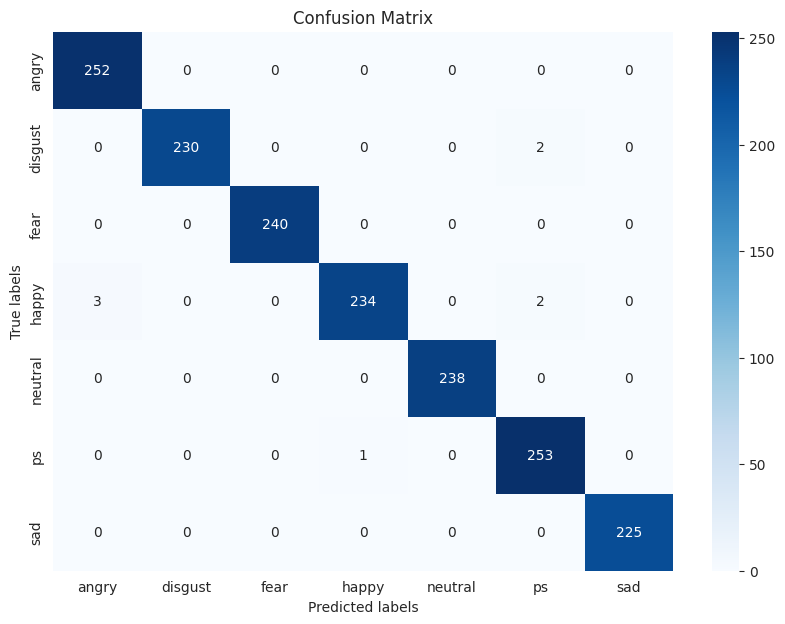

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = svm_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

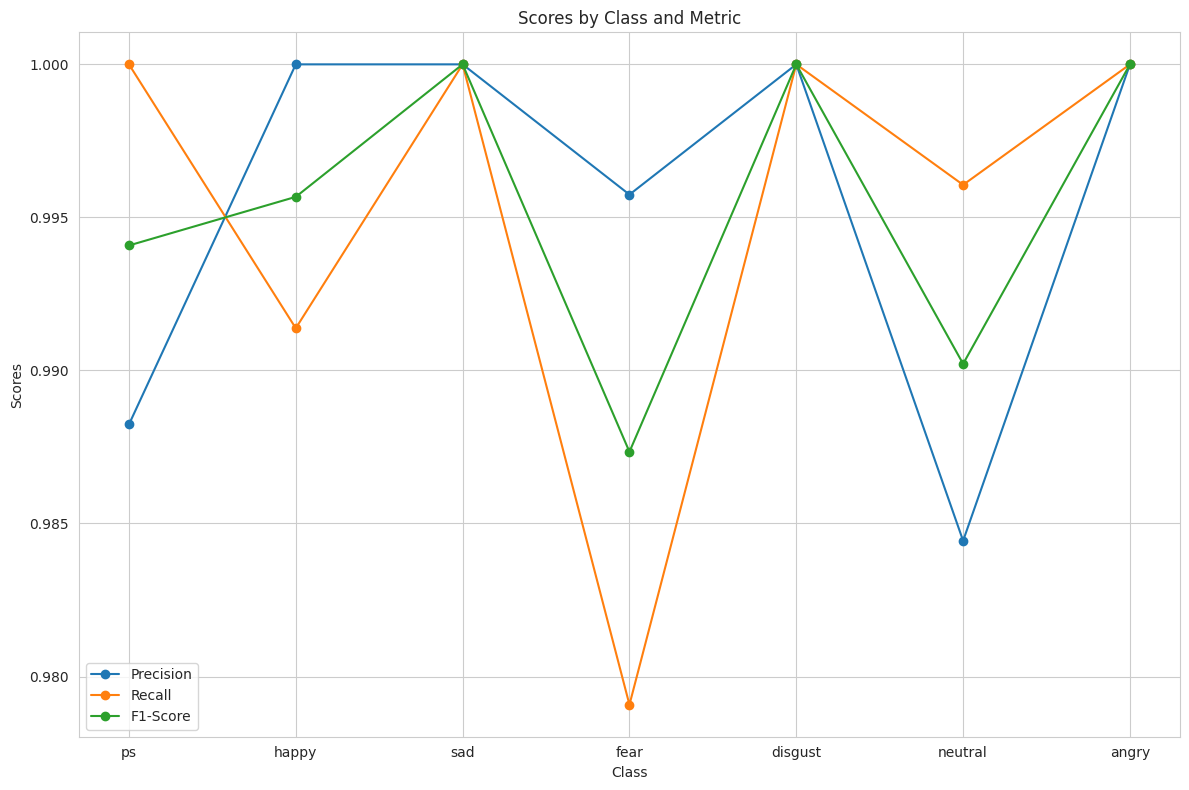

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, labels=np.unique(y_train))
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, fscore]
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(12, 8))
for i, metric in enumerate(metrics):
    ax.plot(x, values[i], marker='o', label=metric)
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Scores by Class and Metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()